In [166]:
import psycopg2 # type: ignore
import matplotlib.pyplot as plt # type: ignore
import pandas as pd # type: ignore
from tqdm import tqdm # type: ignore
import numpy as np # type: ignore
import pandas as pd # type: ignore
import plotly.graph_objects as go # type: ignore
import yfinance as yf # type: ignore
import os
import warnings
warnings.filterwarnings("ignore")
os.chdir("../database")
list_ = os.listdir()

In [167]:
# database initialization
list_ = ["2219.HK", "1093.HK", "6030.HK", "0291.HK", "9961.HK", "6690.HK", "2313.HK", "1928.HK", "0005.HK", "0384.HK",
         "1113.HK", "0981.HK", "0006.HK", "0011.HK", "0003.HK", "1109.HK", "9633.HK", "2899.HK", "1398.HK", "0939.HK",
         "0027.HK", "0823.HK", "0001.HK", "1088.HK", "0386.HK", "0016.HK", "3968.HK", "0002.HK", "0669.HK", "3988.HK",
         "1171.HK", "9868.HK", "2269.HK", "1810.HK", "0700.HK", "2382.HK", "2386.HK", "2318.HK", "0992.HK", "1024.HK",
         "9618.HK", "0883.HK", "0388.HK", "0175.HK", "0941.HK", "2628.HK", "1211.HK", "2388.HK", "9888.HK", "2020.HK", "9988.HK", "1299.HK"]
df = yf.download(list_, start='2018-01-01')
df['Close'].to_parquet("hk_price_close.parquet")
df['Open'].to_parquet("hk_price_open.parquet")

[*********************100%***********************]  52 of 52 completed


In [168]:
open = pd.read_parquet('hk_price_open.parquet')
close = pd.read_parquet('hk_price_close.parquet')

In [169]:
# functions
def get_demean_weighting(factor):
    df1 = factor.dropna(axis='columns', how='all').copy()
    demean = df1.sub(df1.mean(axis=1), axis=0)
    weighting = demean.div(demean.abs().sum(axis=1), axis=0)
    return weighting
def _reweighting_equal(weighting:pd.DataFrame):
    def equal_weight(row: pd.Series):
        count_larger_than_zero = (row != 0).sum()
        if count_larger_than_zero > 0:
            row = row.apply(lambda x: 1 / count_larger_than_zero if x > 0 else x)
        return row
    return weighting.apply(equal_weight, axis=1)
def intraday_shifted_input_signal_pct_output_plot(ln_, pct_calculating_profit, quantile=10, type_='cumsum'):
        
    time_length = len(ln_)
    quantile_column = [[None]*quantile]*time_length
    quantile_df = pd.DataFrame(quantile_column)
    for da in range(time_length):
        row = ln_.iloc[da, :]
        col = row.sort_values(ascending=False).index
        for i in range(0, quantile):
            quantile_df.iloc[da, i] = list(col[i*int(len(row)/quantile):(i+1)*int(len(row)/quantile)])

    # pct_close_w_corres = pct_calculating_profit[pct_calculating_profit.columns.intersection(ln_.columns)].shift(-2)
    holdings = []
    index = ln_.index
    quantiles = [None] * quantile
    for qt_iter in range(quantile):
        quantile_1 = quantile_df.iloc[:, qt_iter]
        if qt_iter == 0: holdings = quantile_1
        df_1 = ln_.copy()
        for i in range(len(quantile_1)):
            df_1.loc[index[i], ~df_1.columns.isin(quantile_1[i])] = 0
        weighting_1 = -_reweighting_equal(df_1)
        ret = pct_calculating_profit.loc[weighting_1.index[0]:] * weighting_1
        if type_ == "cumsum":
            quantiles[qt_iter] = ret.sum(axis=1).cumsum()
        else:
            quantiles[qt_iter] = (1 + ret.sum(axis=1)).cumprod() - 1
    quantilized_cumsum = pd.DataFrame(quantiles).T
    fig = go.Figure()
    for i in range(len(quantilized_cumsum.columns)):
        fig.add_trace(go.Scatter(
            x=quantilized_cumsum.index,
            y=quantilized_cumsum.iloc[:, i],
            name=f"{i} th quantile",
            mode="lines",
            # line=dict(color="orange"),
            yaxis="y1"
        ))
    fig.show()
    # quantilized_cumsum.iloc[:, :].plot(title="10 quantile cumsum distribution")
    return holdings

In [202]:
# momentum: ln(close_/open_)
time_ = "2020-01-01"; end_ = '2025-01-24'
open_ = open[time_:end_]
close_ = close[time_:end_]
ln_ = np.log(close_/open_).shift(1) # index: 使用的時間
pct_calculating_profit = close_/open_-1 # index: 當天收益
holdings = intraday_shifted_input_signal_pct_output_plot(ln_, pct_calculating_profit, quantile=10, type_='cumsum')

In [188]:
close_.iloc[-1][holdings.iloc[-1]], holdings.iloc[-1]

(Ticker
 2219.HK     3.06
 0939.HK     6.29
 1398.HK     5.15
 3988.HK     3.97
 2318.HK    43.25
 Name: 2025-01-24 00:00:00+00:00, dtype: float64,
 ['2219.HK', '0939.HK', '1398.HK', '3988.HK', '2318.HK'])

In [206]:
# momentum: ln(open_/close_.shift(1)) 如果要更保守，就li_.shift(1)
time_ = "2018-01-15"; end_ = '2025-01-24'
open_ = open[time_:end_]
close_ = close[time_:end_]
ln_ = np.log(open_/close_.shift(1)) # index: 使用的時間
pct_calculating_profit = close_/open_-1 # index: 當天收益
holdings = intraday_shifted_input_signal_pct_output_plot(ln_.shift(0), pct_calculating_profit.shift(-1), quantile=10, type_='cumsum')

In [213]:
(pct_calculating_profit.iloc[1] * ln_.iloc[1]).sum()

np.float64(0.00010390949819606964)

<Axes: >

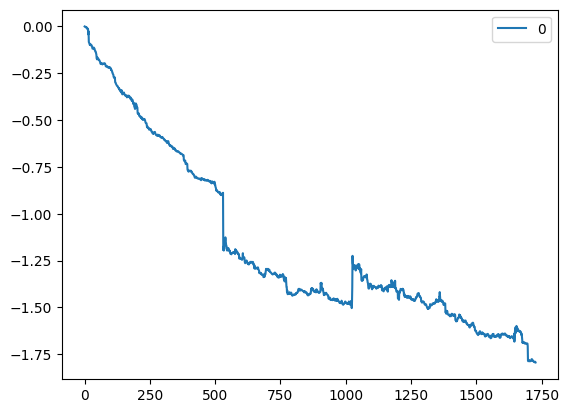

In [221]:
test = []
for t in range(1, len(ln_)-1):
    signal = ln_.iloc[t]  # 當天生成信號
    profit_t_plus_1 = pct_calculating_profit.iloc[t]  # 使用下一天的收益計算績效
    test.append((signal * profit_t_plus_1).sum())
pd.DataFrame(test).cumsum().plot()

In [172]:
# 今天的open_ 要和昨天的close_計算，所以是 open_.shift(0) 配上 close_.shift(1)

In [196]:
holdings

0       [0001.HK, 0002.HK, 0003.HK, 0005.HK, 0006.HK]
1       [0386.HK, 0384.HK, 0883.HK, 1299.HK, 2020.HK]
2       [2382.HK, 1088.HK, 0011.HK, 1299.HK, 0823.HK]
3       [2313.HK, 3988.HK, 2382.HK, 2386.HK, 6030.HK]
4       [2382.HK, 2020.HK, 0669.HK, 0981.HK, 0700.HK]
                            ...                      
1725    [9618.HK, 1024.HK, 9988.HK, 9888.HK, 1810.HK]
1726    [0669.HK, 9961.HK, 2020.HK, 2313.HK, 6690.HK]
1727    [0981.HK, 0384.HK, 2899.HK, 2388.HK, 0006.HK]
1728    [6030.HK, 0981.HK, 9988.HK, 2628.HK, 0175.HK]
1729    [9961.HK, 0981.HK, 2219.HK, 0388.HK, 1299.HK]
Name: 0, Length: 1730, dtype: object

In [184]:
close_.iloc[-1][holdings.iloc[-1]], holdings.iloc[-1]

(Ticker
 9961.HK    534.000000
 0981.HK     39.849998
 2219.HK      3.060000
 0388.HK    295.799988
 1299.HK     54.599998
 Name: 2025-01-24 00:00:00+00:00, dtype: float64,
 ['9961.HK', '0981.HK', '2219.HK', '0388.HK', '1299.HK'])

# Medium-length

In [ ]:
# 2020-01-10: 2020-01-03 ~ 2020-01-10 的累積收益 => 
# 1. Momentum 用上禮拜開~收盤:
#   => 算出來的ln_會是index 對標產生的日期 => 對應下禮拜2020-01-13 ~ 2020-01-17 開盤到收盤的收益
#   => W-FRI 01-10 => W-MON 01-20 // W-FRI x W-MON.shift(-1)

In [324]:
def intraday_shifted_input_signal_pct_output_plot(ln_, pct_calculating_profit, quantile=10, type_='cumsum'):
        
    time_length = len(ln_)
    quantile_column = [[None]*quantile]*time_length
    quantile_df = pd.DataFrame(quantile_column)
    for da in range(time_length):
        row = ln_.iloc[da, :]
        col = row.sort_values(ascending=False).index
        for i in range(0, quantile):
            quantile_df.iloc[da, i] = list(col[i*int(len(row)/quantile):(i+1)*int(len(row)/quantile)])

    # pct_close_w_corres = pct_calculating_profit[pct_calculating_profit.columns.intersection(ln_.columns)].shift(-2)
    holdings = []
    index = ln_.index
    quantiles = [None] * quantile
    for qt_iter in range(quantile):
        quantile_1 = quantile_df.iloc[:, qt_iter]
        if qt_iter == 0: 
            holdings = quantile_1
            holdings.index = pct_calculating_profit.index0
        df_1 = ln_.copy()
        for i in range(len(quantile_1)):
            df_1.loc[index[i], ~df_1.columns.isin(quantile_1[i])] = 0
        weighting_1 = _reweighting_equal(df_1)
        ret = pct_calculating_profit.loc[weighting_1.index[0]:] * weighting_1
        if type_ == "cumsum":
            quantiles[qt_iter] = ret.sum(axis=1).cumsum()
        else:
            quantiles[qt_iter] = (1 + ret.sum(axis=1)).cumprod() - 1
    quantilized_cumsum = pd.DataFrame(quantiles).T
    fig = go.Figure()
    for i in range(len(quantilized_cumsum.columns)):
        fig.add_trace(go.Scatter(
            x=quantilized_cumsum.index,
            y=quantilized_cumsum.iloc[:, i],
            name=f"{i} th quantile",
            mode="lines",
            # line=dict(color="orange"),
            yaxis="y1"
        ))
    fig.show()
    # quantilized_cumsum.iloc[:, :].plot(title="10 quantile cumsum distribution")
    return holdings

In [316]:
open_w = open.copy()
close_w = close.copy()
timie_w = "2024-01-01"
timie_end = "2025-01-25"
open_w = open_w.loc[timie_w:timie_end]
close_w = close_w.loc[timie_w:timie_end]
pct_open = open_w.pct_change()
fri = pct_open.resample("W-FRI").sum() # ln_
mon = pct_open.resample("W-MON").sum().shift(1) # pct_calculating_profit
mon.index = fri.index


holdings = intraday_shifted_input_signal_pct_output_plot(
    mon, 
    fri,
    quantile=10, 
    type_='cumsum')


In [319]:
fri.iloc[-1].sort_values(ascending=False).head(10)

Ticker
2219.HK    0.132468
0981.HK    0.100013
9618.HK    0.095183
2382.HK    0.089352
2628.HK    0.055664
9988.HK    0.047507
2318.HK    0.046939
0388.HK    0.045097
1211.HK    0.042717
9868.HK    0.041184
Name: 2025-01-24 00:00:00+00:00, dtype: float64

In [321]:
holdings.tail(), close_.iloc[-1][fri.iloc[-1].sort_values(ascending=False).head(10).index], holdings.iloc[-1]

# 2219.HK    0.132468
# 0981.HK    0.100013
# 9618.HK    0.095183
# 2382.HK    0.089352
# 2628.HK    0.055664

(Date
 2024-12-27 00:00:00+00:00    [0981.HK, 2382.HK, 0700.HK, 9868.HK, 2313.HK]
 2025-01-03 00:00:00+00:00    [0992.HK, 1810.HK, 0981.HK, 1398.HK, 0883.HK]
 2025-01-10 00:00:00+00:00    [1810.HK, 2313.HK, 0883.HK, 2899.HK, 1171.HK]
 2025-01-17 00:00:00+00:00    [0981.HK, 9868.HK, 2899.HK, 2020.HK, 0005.HK]
 2025-01-24 00:00:00+00:00    [0981.HK, 9618.HK, 9868.HK, 3968.HK, 6030.HK]
 Freq: W-FRI, Name: 0, dtype: object,
 Ticker
 2219.HK      3.060000
 0981.HK     39.849998
 9618.HK    150.699997
 2382.HK     69.099998
 2628.HK     14.260000
 9988.HK     83.400002
 2318.HK     43.250000
 0388.HK    295.799988
 1211.HK    271.000000
 9868.HK     56.250000
 Name: 2025-01-24 00:00:00+00:00, dtype: float64,
 ['0981.HK', '9618.HK', '9868.HK', '3968.HK', '6030.HK'])

In [ ]:
for week in range(len(mon)):
    signal = mon.iloc[week]  # 上一周的信號
    profit = fri.iloc[week]  # 當周的收益


<Axes: xlabel='Date'>

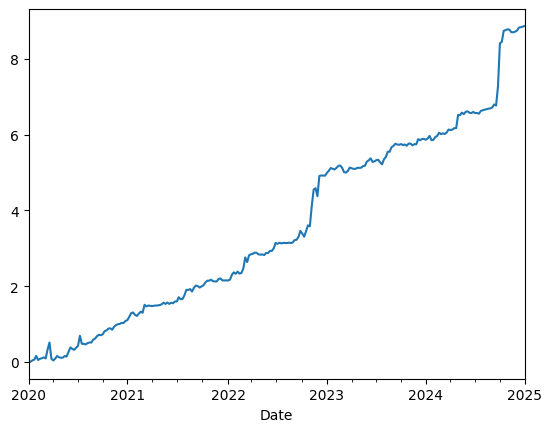

In [247]:
(mon * fri).sum(axis=1).cumsum().plot()

# Monthly Swing HK

In [ ]:
# ln_ 取負號或是 weighting_ 取負號的效果不一樣，並且對weighting 取負號效果比較好

In [456]:
open_.head()

Ticker,0001.HK,0002.HK,0003.HK,0005.HK,0006.HK,0011.HK,0016.HK,0027.HK,0175.HK,0291.HK,...,3968.HK,3988.HK,6030.HK,6690.HK,9618.HK,9633.HK,9868.HK,9888.HK,9961.HK,9988.HK
Date,,,,,,,,,,,,,,,,,,,,,
2018-10-15 00:00:00+00:00,81.500000,87.900002,12.104720,65.400002,53.099998,204.000000,104.000000,45.200001,14.08,28.500000,...,28.900000,3.29,11.736308,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-10-16 00:00:00+00:00,81.500000,86.599998,12.121212,65.199997,52.849998,204.600006,104.400002,44.650002,14.20,28.450001,...,29.250000,3.26,11.716748,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-10-18 00:00:00+00:00,79.949997,87.199997,12.137703,64.800003,53.000000,202.800003,102.199997,45.200001,14.40,27.799999,...,29.450001,3.27,11.971034,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-10-19 00:00:00+00:00,79.800003,87.150002,12.170686,63.349998,52.549999,201.000000,102.800003,44.599998,13.28,27.000000,...,28.700001,3.22,11.540703,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-10-22 00:00:00+00:00,79.949997,88.199997,12.418058,63.549999,52.849998,201.399994,103.400002,45.849998,14.14,29.600000,...,29.799999,3.28,12.107958,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [457]:
close_.head()

Ticker,0001.HK,0002.HK,0003.HK,0005.HK,0006.HK,0011.HK,0016.HK,0027.HK,0175.HK,0291.HK,...,3968.HK,3988.HK,6030.HK,6690.HK,9618.HK,9633.HK,9868.HK,9888.HK,9961.HK,9988.HK
Date,,,,,,,,,,,,,,,,,,,,,
2018-10-15 00:00:00+00:00,81.250000,86.900002,12.137703,64.750000,52.549999,203.199997,103.699997,44.549999,13.84,28.000000,...,28.900000,3.25,11.677627,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-10-16 00:00:00+00:00,80.750000,86.699997,12.137703,64.800003,52.900002,203.000000,102.900002,44.900002,14.04,27.000000,...,29.250000,3.25,11.755869,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-10-18 00:00:00+00:00,80.750000,87.500000,12.170686,64.550003,53.000000,202.000000,102.800003,45.349998,13.70,27.049999,...,28.750000,3.23,11.716748,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-10-19 00:00:00+00:00,80.400002,88.599998,12.385075,63.849998,53.000000,201.000000,103.400002,45.599998,14.02,28.049999,...,29.650000,3.28,11.951474,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-10-22 00:00:00+00:00,81.750000,88.750000,12.451041,64.349998,53.450001,203.399994,104.099998,47.200001,15.12,29.100000,...,30.700001,3.34,13.418512,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [455]:
ln_.head()

Ticker,0001.HK,0002.HK,0003.HK,0005.HK,0006.HK,0011.HK,0016.HK,0027.HK,0175.HK,0291.HK,...,3968.HK,3988.HK,6030.HK,6690.HK,9618.HK,9633.HK,9868.HK,9888.HK,9961.HK,9988.HK
Date,,,,,,,,,,,,,,,,,,,,,
2018-10-15 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-10-16 00:00:00+00:00,0.003072,-0.003458,-0.00136,0.006926,0.005693,0.006866,0.006728,0.002242,0.025679,0.015944,...,0.012038,0.003072,0.003345,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-10-18 00:00:00+00:00,-0.009957,0.005750,0.00000,0.000000,0.001889,-0.000986,-0.006826,0.006659,0.025318,0.029199,...,0.006814,0.006135,0.018137,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-10-19 00:00:00+00:00,-0.011834,-0.004008,0.00000,-0.018765,-0.008527,-0.004963,0.000000,-0.016676,-0.031137,-0.001850,...,-0.001741,-0.003101,-0.015139,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-10-22 00:00:00+00:00,-0.005613,-0.004525,0.00266,-0.004710,-0.002834,0.001988,0.000000,0.005467,0.008523,0.053786,...,0.005046,0.000000,0.013008,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [453]:
# momentum: ln(open_/close_.shift(1)) 如果要更保守，就li_.shift(1)
time_ = "2018-10-15"; end_ = '2025-01-24'
open_ = open[time_:end_]
close_ = close[time_:end_]
ln_ = np.log(open_/close_.shift(1)) # index: 使用的時間
pct_calculating_profit = close_/open_-1 # index: 當天收益
holdings = intraday_shifted_input_signal_pct_output_plot(ln_.shift(0), pct_calculating_profit.shift(0), quantile=10, type_='cumsum')

In [477]:
import numpy as np
import pandas as pd

# 皮爾遜相關係數計算函數
def pearson_correlation(x, y):
    n = len(x)
    x_mean = sum(x) / n
    y_mean = sum(y) / n

    numerator = sum((x[i] - x_mean) * (y[i] - y_mean) for i in range(n))
    denominator = (sum((x[i] - x_mean) ** 2 for i in range(n)) * sum((y[i] - y_mean) ** 2 for i in range(n))) ** 0.5

    return numerator / denominator if denominator != 0 else 0

# 斯皮爾曼秩相關係數計算函數
def spearman_correlation(x, y):
    n = len(x)
    
    # 計算排名
    x_ranks = pd.Series(x).rank().tolist()
    y_ranks = pd.Series(y).rank().tolist()

    # 計算 d_i^2
    d_squared = sum((x_ranks[i] - y_ranks[i]) ** 2 for i in range(n))

    # 斯皮爾曼相關係數公式
    rho = 1 - (6 * d_squared) / (n * (n ** 2 - 1))

    return rho

def plots(k, l):
    fig = go.Figure()
    fig.add_trace(
        go.Scatter(
            x=k.index,
            y=l,
            mode="lines",
            name="Cumulative Percentage Change",
            yaxis="y1",  # Map to primary y-axis
            line=dict(color="blue")
        )
    )

    # Add scatter plot (or histogram) for IR
    fig.add_trace(
        go.Bar(
            x=k.index,
            y=k,
            name="Information Ratio (Bar)",
            yaxis="y2",  # Map to secondary y-axis
            marker=dict(color="red", opacity=0.6)
        )
    )

    # Set up layout with dual y-axes
    fig.update_layout(
        title="Cumulative % Change vs Information Ratio",
        xaxis=dict(title="Date"),
        yaxis=dict(
            title="Cumulative % Change",
            titlefont=dict(color="blue"),
            tickfont=dict(color="blue")
        ),
        yaxis2=dict(
            title="Information Ratio",
            titlefont=dict(color="red"),
            tickfont=dict(color="red"),
            overlaying="y",
            side="right"  # Position y2 axis on the right
        ),
        legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1)
    )
    fig.show()
# 測試數據
indexer = -7
data_factor = ln_.iloc[1:, indexer]  # 因1分數
data_return = pct_calculating_profit.iloc[1:, indexer]

# 計算相關係數
pearson_result = pearson_correlation(data_factor, data_return)
spearman_result = spearman_correlation(data_factor, data_return)

print(f"Pearson Correlation: {pearson_result:.4f}")
print(f"Spearman Correlation: {spearman_result:.4f}")

k = ln_['9868.HK'].apply(lambda x: -1 if x >= 0 else 1)
l = (pct_calculating_profit['9868.HK'].shift(0) * k).cumsum()
plots(k, l)

Pearson Correlation: nan
Spearman Correlation: nan


Mean correlation coefficient: -0.06997916923371411


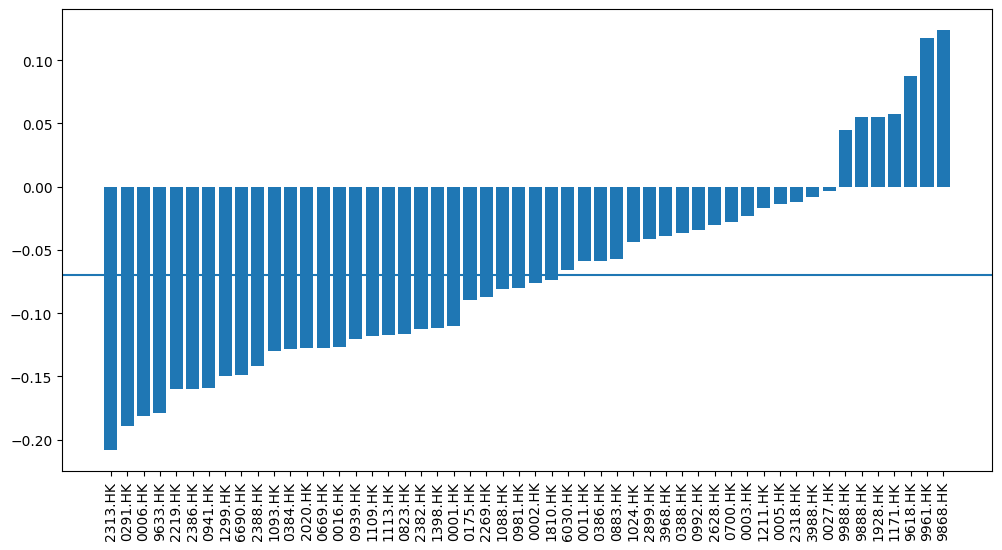

In [476]:
ind_corrcoef = pd.Series()
ln_cols = list(ln_.columns)
ln_array = np.array(ln_.iloc[1:, :]).T
pct_array = np.array(pct_calculating_profit.iloc[1:, :]).T
for i in range(ln_array.shape[0]):
    # Combine ln_array[i] and pct_array[i], then filter out rows where either array has NaN
    valid_mask = ~np.isnan(ln_array[i]) & ~np.isnan(pct_array[i])  # Boolean mask for valid data
    if valid_mask.any():  # Only compute correlation if there's at least one valid data point
        corr = np.corrcoef(ln_array[i][valid_mask], pct_array[i][valid_mask])[0, 1]
        ind_corrcoef[ln_cols[i]] = corr
    else:
        ind_corrcoef[ln_cols[i]] = np.nan  # If no valid data, append NaN

# Plot and calculate the mean of non-NaN correlation coefficients
ind_corrcoef = ind_corrcoef.sort_values(ascending=True)
mean_corrcoef = np.nanmean(ind_corrcoef)  # np.nanmean automatically ignores NaNs
plt.figure(figsize=(12, 6))
plt.bar(ind_corrcoef.index, ind_corrcoef)
plt.axhline(mean_corrcoef)
plt.xticks(rotation=90)
print("Mean correlation coefficient:", mean_corrcoef)


(<BarContainer object of 52 artists>, np.float64(-0.06399692743351883))

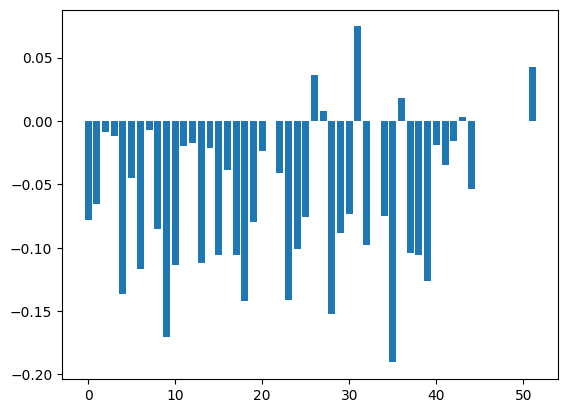

In [375]:
ln_array = np.array(ln_.iloc[1:, :]).T
pct_array = np.array(pct_calculating_profit.iloc[1:, :]).T
ind_corrcoef = [np.corrcoef(ln_array[i], pct_array[i])[0, 1] for i in range(ln_array.shape[0])]
plt.bar(np.arange(len(ind_corrcoef)), ind_corrcoef), np.mean(np.array(ind_corrcoef)[~np.isnan(ind_corrcoef)])